In [20]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [21]:
%load_ext line_profiler

## Data

In [37]:
def _prepare_data(pattern, random_seed:int=2019):
    filepaths = glob(pattern)
    data = pd.concat([pd.read_csv(f, index_col=0, parse_dates=['closed_date', 'created_date']) for f in filepaths], sort=False)
    
    data = data[data.complaint_type.str.lower().str.contains('noise')]
    data.reset_index(drop=True, inplace=True)
    data = data.dropna(subset=['x_coordinate_state_plane', 'y_coordinate_state_plane', 'created_date', 'closed_date', 'complaint_type', 'open_data_channel_type'])
    
    
    sample = data.sample(10_000, random_state=random_seed)
    
    X = pd.concat([sample[['x_coordinate_state_plane',
                     'y_coordinate_state_plane']],
                   sample['created_date'].dt.dayofweek,
                   sample['created_date'].dt.hour,
                   sample['created_date'].dt.dayofyear],
              sort=False, axis=1)
    
    y = (data['closed_date'] - data['created_date']).dt.seconds / 3600 
    
    return X, y[X.index]

In [34]:
pattern = '../Chapter16/data/311/2019/05/*.csv'

In [35]:
glob(pattern)

['../Chapter16/data/311/2019/05/23.csv',
 '../Chapter16/data/311/2019/05/22.csv',
 '../Chapter16/data/311/2019/05/08.csv',
 '../Chapter16/data/311/2019/05/20.csv',
 '../Chapter16/data/311/2019/05/21.csv',
 '../Chapter16/data/311/2019/05/09.csv',
 '../Chapter16/data/311/2019/05/25.csv',
 '../Chapter16/data/311/2019/05/31.csv',
 '../Chapter16/data/311/2019/05/19.csv',
 '../Chapter16/data/311/2019/05/18.csv',
 '../Chapter16/data/311/2019/05/30.csv',
 '../Chapter16/data/311/2019/05/24.csv',
 '../Chapter16/data/311/2019/05/26.csv',
 '../Chapter16/data/311/2019/05/27.csv',
 '../Chapter16/data/311/2019/05/16.csv',
 '../Chapter16/data/311/2019/05/02.csv',
 '../Chapter16/data/311/2019/05/03.csv',
 '../Chapter16/data/311/2019/05/17.csv',
 '../Chapter16/data/311/2019/05/29.csv',
 '../Chapter16/data/311/2019/05/01.csv',
 '../Chapter16/data/311/2019/05/15.csv',
 '../Chapter16/data/311/2019/05/14.csv',
 '../Chapter16/data/311/2019/05/28.csv',
 '../Chapter16/data/311/2019/05/04.csv',
 '../Chapter16/d

In [25]:
X, y = _prepare_data(pattern, random_seed=2019)

In [26]:
S = StandardScaler()

In [27]:
X = pd.DataFrame(S.fit_transform(X), columns=X.columns, index=X.index)

In [28]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=2019)

# 1. "Naive" pandas model

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import r2_score, median_absolute_error

def _closest_N(X1, X2, N=1):
    matrix = euclidean_distances(X1, X2)
    args = np.argsort(matrix, axis=1)[:, :N]
    return args


class NearestNeighbor:
    X = None
    y = None
    N = None
    
    
    def __init__(self, N=3):
        self.N=N
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    

    def predict(self, X):
        closest = _closest_N(X, self.X, N=self.N)
        
        result = pd.Series(np.mean(np.take(ytrain.values, closest), axis=1))
        result.index = X.index
        return result
        

In [11]:
naiveKNN = NearestNeighbor(N=5)

In [12]:
naiveKNN.fit(Xtrain, ytrain)

In [13]:
ypred = naiveKNN.predict(Xtest)

In [14]:
median_absolute_error(ytest, ypred)

1.8625277777777778

## Let's Time it

In [15]:
Xtest.shape

(2500, 5)

In [16]:
%%timeit
naiveKNN.predict(Xtest);

1.59 s ± 78.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%lprun -f naiveKNN.predict naiveKNN.predict(Xtest)

Timer unit: 1e-06 s

Total time: 1.55681 s
File: <ipython-input-10-90edea23066c>
Function: predict at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                               def predict(self, X):
    25         1    1556123.0 1556123.0    100.0          closest = _closest_N(X, self.X, N=self.N)
    26                                                   
    27         1        666.0    666.0      0.0          result = pd.Series(np.mean(np.take(ytrain.values, closest), axis=1))
    28         1         21.0     21.0      0.0          result.index = X.index
    29         1          0.0      0.0      0.0          return result

In [18]:
%lprun -f _closest_N naiveKNN.predict(Xtest)

Timer unit: 1e-06 s

Total time: 1.57069 s
File: <ipython-input-10-90edea23066c>
Function: _closest_N at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def _closest_N(X1, X2, N=1):
     5         1     221777.0 221777.0     14.1      matrix = euclidean_distances(X1, X2)
     6         1    1348917.0 1348917.0     85.9      args = np.argsort(matrix, axis=1)[:, :N]
     7         1          1.0      1.0      0.0      return args

## More thorough version

In [19]:
def _test_closest(f):
    x1 = pd.DataFrame({'a':[1,2], 'b':[20,10]})
    x2 = pd.DataFrame({'a':[2,1, 0], 'b':[10,20, 25]})
 
    answer = np.array([[1,0, 0]]).T
    assert np.all(f(x2, x1, N=1) == answer)

In [20]:
def _closest_N2(X1, X2, N=1):
    matrix = euclidean_distances(X1, X2)
    return np.argpartition(matrix, kth=N, axis=1)[:, :N]

In [21]:
_test_closest(_closest_N2)

In [22]:
class numpyNearestNeighbour(NearestNeighbor):
    
    
    def predict(self, X):
            closest = _closest_N2(X, self.X, N=self.N)
            return np.mean(np.take(self.y, closest), axis=1)

In [23]:
numpyKNN = numpyNearestNeighbour(N=5)
numpyKNN.fit(Xtrain.values, ytrain.values)

In [24]:
ypred = numpyKNN.predict(Xtest.values)

In [25]:
median_absolute_error(ytest.values, ypred)

1.8564722222222225

In [26]:
Xtv = Xtest.values

In [27]:
%%timeit
_ = numpyKNN.predict(Xtv)

518 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%lprun -f _closest_N2 numpyKNN.predict(Xtv)

Timer unit: 1e-06 s

Total time: 0.528009 s
File: <ipython-input-20-29fa1851d880>
Function: _closest_N2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def _closest_N2(X1, X2, N=1):
     2         1     245185.0 245185.0     46.4      matrix = euclidean_distances(X1, X2)
     3         1     282824.0 282824.0     53.6      return np.argpartition(matrix, kth=N, axis=1)[:, :N]

## KDtree version

In [29]:
from scipy.spatial import cKDTree, KDTree

class kdNearestNeighbour:
    _kd = None
    y = None
    
    def __init__(self, N=3):
        self.N=N
    
    def fit(self, X, y):
        self._kd = cKDTree(X, leafsize=2*self.N)
        self.y = y
    

    def predict(self, X):
        d, closest = self._kd.query(X, k=self.N)
        return d, np.mean(np.take(ytrain.values, closest), axis=1)
  

In [30]:
kdKNN = kdNearestNeighbour(N=5)
kdKNN.fit(Xtrain.values, ytrain.values)

In [31]:
d, ypred = kdKNN.predict(Xtest.values)

In [32]:
type(ypred)

numpy.ndarray

In [33]:
%%timeit
_ = kdKNN.predict(Xtv)

14.2 ms ± 989 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
%lprun -f kdKNN.predict kdKNN.predict(Xtv)

Timer unit: 1e-06 s

Total time: 0.018218 s
File: <ipython-input-29-7ab441d7403e>
Function: predict at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                               def predict(self, X):
    16         1      18014.0  18014.0     98.9          d, closest = self._kd.query(X, k=self.N)
    17         1        204.0    204.0      1.1          return d, np.mean(np.take(ytrain.values, closest), axis=1)

# Dask

In [9]:
from dask import dataframe as dd
from dask import delayed
import dask
dask.config.set(scheduler='processes')

In [36]:
# %timeit _prepare_data(filepaths, random_seed=2019)

In [53]:
from dask import dataframe as dd
pattern = '../Chapter16/data/311/2019/05/*.csv'

df = dd.read_csv(pattern, blocksize=None, parse_dates=['closed_date', 'created_date'], dtype=str)

In [54]:
df = df[df.complaint_type.str.lower().str.contains('noise')]
cols = ['x_coordinate_state_plane', 'y_coordinate_state_plane', 'created_date', 'closed_date', 'complaint_type', 'open_data_channel_type']

df = df.dropna(subset=cols)

X = df[['x_coordinate_state_plane', 'y_coordinate_state_plane']]
X['dow'] = df['created_date'].dt.dayofweek
X['hour'] = df['created_date'].dt.dayofweek
X['doy'] = df['created_date'].dt.dayofyear

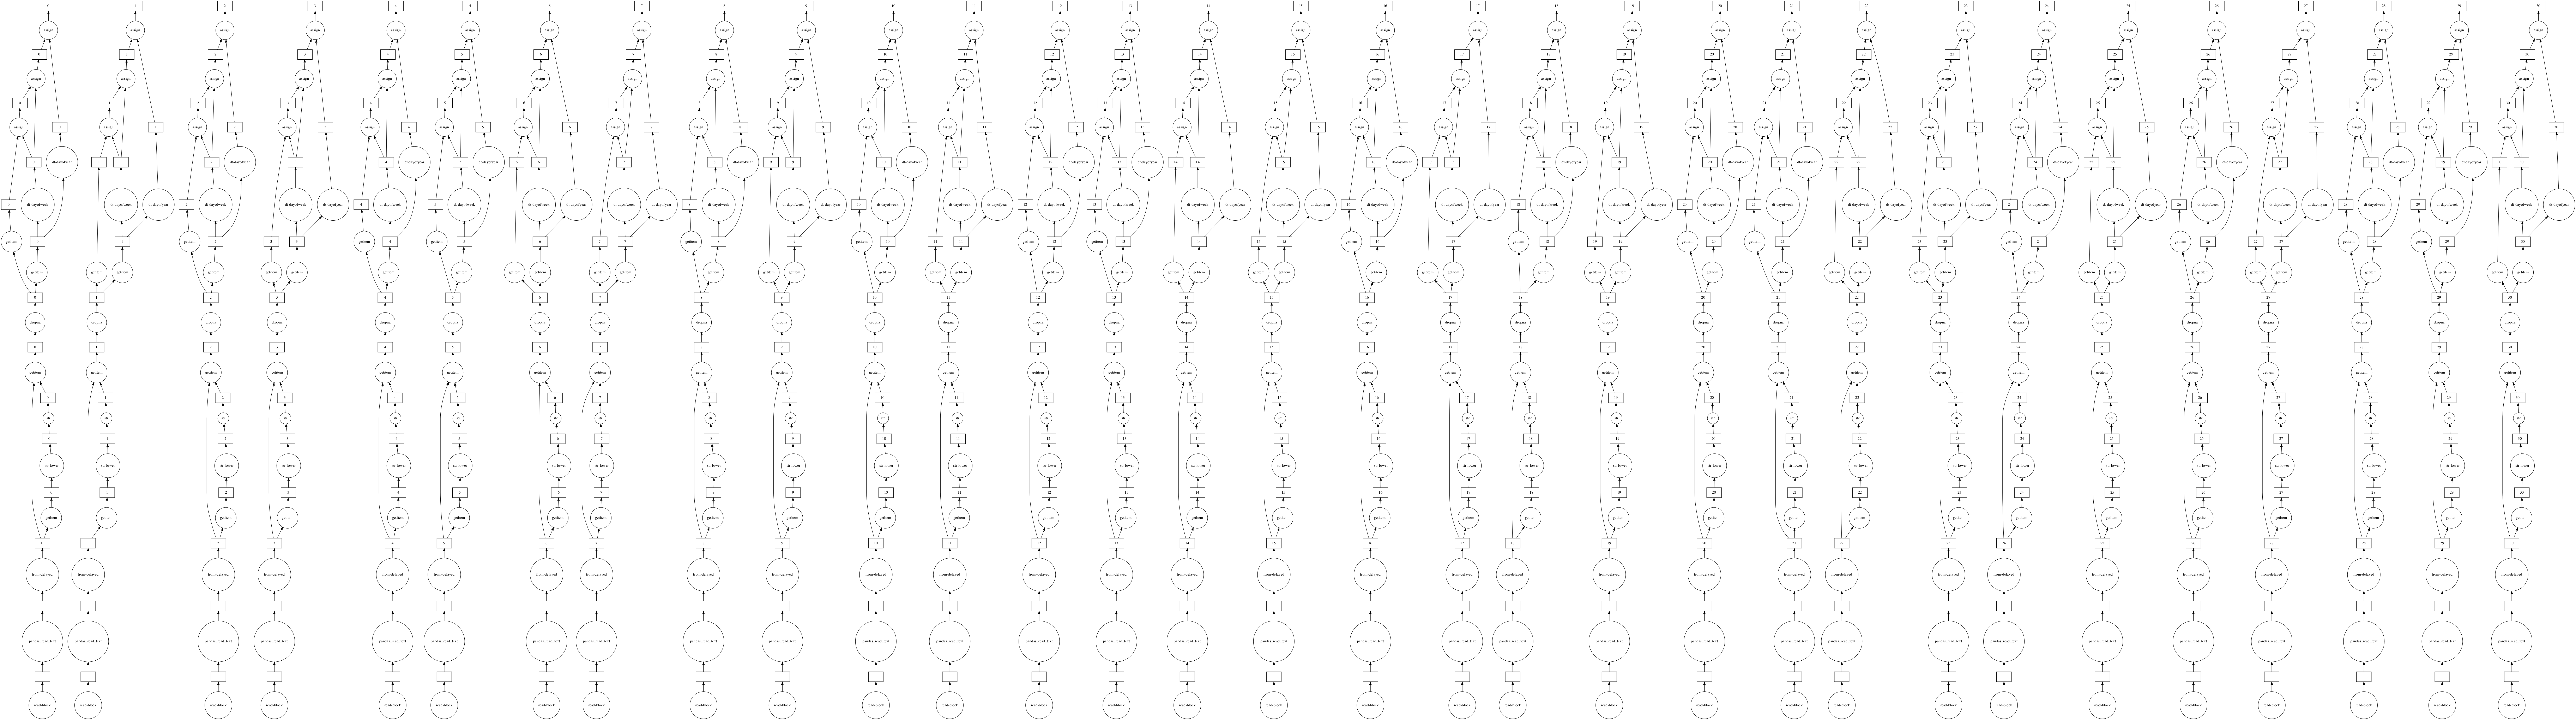

In [55]:
X.visualize(filename='chart.png')

In [65]:
X

,x_coordinate_state_plane,y_coordinate_state_plane,dow,hour,doy
npartitions=31,,,,,
,object,object,int64,int64,int64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [64]:
X.head(10)

,x_coordinate_state_plane,y_coordinate_state_plane,dow,hour,doy
11,994436,170735,2,2,121
12,989050,209585,2,2,121
15,996313,218460,2,2,121
16,998201,188782,2,2,121
23,998201,188782,2,2,121
24,1034246,263365,2,2,121
29,1019458,212892,2,2,121
34,1001534,235999,2,2,121
35,990874,186602,2,2,121
37,987667,204724,2,2,121


# Numba

In [16]:
import numba
from numba import jit, vectorize, generated_jit, jitclass
from numba.types import iterators, float64, int32

In [11]:
def distance(p1, p2):
    
    distance = 0
    for c1, c2, in zip(p1,p2):
        distance += (c2-c1)**2
    
    return np.sqrt(distance)



def compute_distances(points1, points2):
    A = np.zeros(shape=(len(points1), len(points2)))
                 
    for i, p1 in enumerate(points1):
        for j, p2 in enumerate(points2):
                 A[i, j] = distance(p1, p2)
    
    return A

In [12]:
%timeit compute_distances([(0, 0)]*100, [(1,1)]*200)

46.2 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
@jit()
def distance(p1, p2):
    
    distance = 0
    for c1, c2, in zip(p1,p2):
        distance += (c2-c1)**2
    
    return np.sqrt(distance)


@jit()
def compute_distances(points1, points2):
    A = np.zeros(shape=(len(points1), len(points2)))
                 
    for i, p1 in enumerate(points1):
        for j, p2 in enumerate(points2):
                 A[i, j] = distance(p1, p2)
    
    return A

In [14]:
%timeit compute_distances([(0, 0)]*100, [(1,1)]*200)

/anaconda3/envs/packt/lib/python3.7/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'points1' of function 'compute_distances'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-13-34196df9bc05>", line 12:
@jit()
def compute_distances(points1, points2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/anaconda3/envs/packt/lib/python3.7/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'points2' of function 'compute_distances'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-13-34196df9bc

3.79 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
